In [22]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

In [5]:
train_data = pd.read_csv('../Dataset/train.csv')
test_data = pd.read_csv('../Dataset/test.csv')
test_data_labels = pd.read_csv('../Dataset/test_labels.csv')
display(train_data.head())
display(test_data.head())
display(test_data_labels.head())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [ ]:
# # Download NLTK resources
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt_tab')

# Initialize lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [10]:
# Define preprocessing functions
def clean_text(text):
    """Basic text cleaning: lowercase, remove special chars, etc."""
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    else:
        return ""

def remove_stopwords(text):
    """Remove stopwords from text"""
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

def lemmatize_text(text):
    """Lemmatize text"""
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

def stem_text(text):
    """Stem text"""
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

def preprocess_text(text, remove_stops=True, lemmatize=True, stem=False):
    """Complete preprocessing pipeline"""
    # Basic cleaning
    text = clean_text(text)
    
    # Remove stopwords if specified
    if remove_stops:
        text = remove_stopwords(text)
    
    # Lemmatize if specified (typically we choose either lemmatization OR stemming)
    if lemmatize:
        text = lemmatize_text(text)
    
    # Stem if specified
    if stem:
        text = stem_text(text)
    
    return text

In [14]:
# train_data

In [17]:
# Apply preprocessing to the datasets
# First, create a copy to avoid modifying original data
train_processed = train_data.copy()
test_processed = test_data.copy()

# Apply preprocessing to comment_text column
print("Preprocessing training data...")
train_processed['processed_text'] = train_processed['comment_text'].apply(
    lambda x: preprocess_text(x, remove_stops=True, lemmatize=True, stem=False)
)

print("Preprocessing test data...")
test_processed['processed_text'] = test_processed['comment_text'].apply(
    lambda x: preprocess_text(x, remove_stops=True, lemmatize=True, stem=False)
)

# Display examples of original vs processed text
print("\nExample of original vs processed text:")
for i in range(3):
    print(f"Original: {train_data['comment_text'].iloc[i][:100]}...")
    print(f"Processed: {train_processed['processed_text'].iloc[i][:100]}...")
    print()

Preprocessing training data...
Preprocessing test data...

Example of original vs processed text:
Original: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't ...
Processed: explanation edits made username hardcore metallica fan reverted werent vandalism closure gas voted n...

Original: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11...
Processed: daww match background colour im seemingly stuck thanks talk january utc...

Original: Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant ...
Processed: hey man im really trying edit war guy constantly removing relevant information talking edits instead...



Average text length reduction: 38.71%


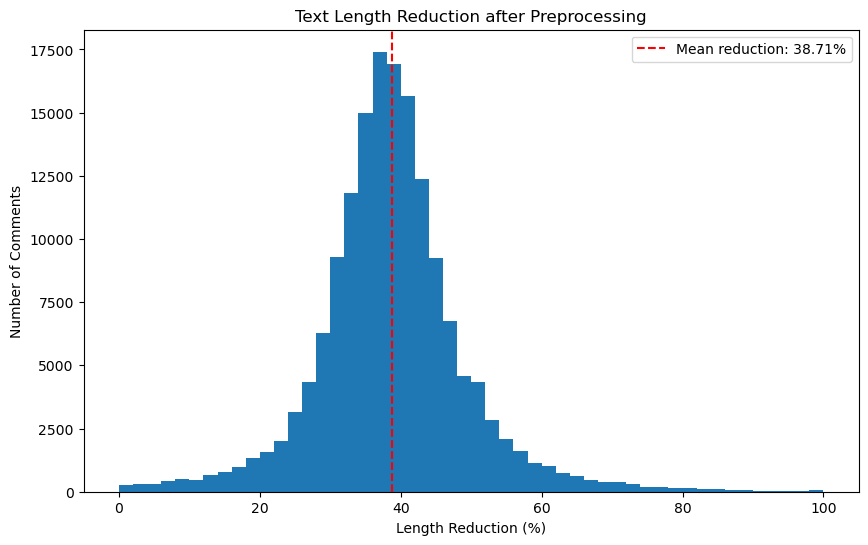

In [18]:
# Analyze the effect of preprocessing
# Check length reduction
train_processed['original_length'] = train_processed['comment_text'].apply(len)
train_processed['processed_length'] = train_processed['processed_text'].apply(len)
train_processed['length_reduction'] = (1 - train_processed['processed_length'] / train_processed['original_length']) * 100

print(f"Average text length reduction: {train_processed['length_reduction'].mean():.2f}%")

# Visualize length reduction
plt.figure(figsize=(10, 6))
plt.hist(train_processed['length_reduction'], bins=50)
plt.axvline(train_processed['length_reduction'].mean(), color='r', linestyle='--', 
           label=f'Mean reduction: {train_processed["length_reduction"].mean():.2f}%')
plt.xlabel('Length Reduction (%)')
plt.ylabel('Number of Comments')
plt.title('Text Length Reduction after Preprocessing')
plt.legend()
plt.show()

Original vocabulary size: 532,299
Processed vocabulary size: 205,885
Vocabulary reduction: 61.32%


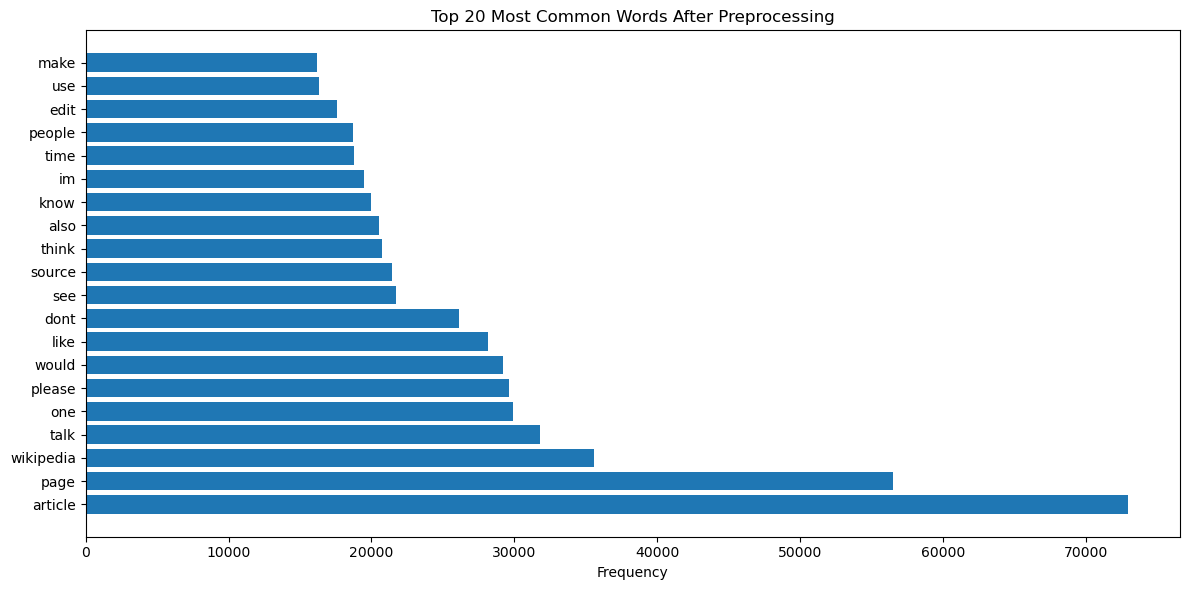

In [19]:
# Look at the vocabulary before and after preprocessing
def get_vocabulary_size(texts):
    all_words = ' '.join(texts).split()
    unique_words = set(all_words)
    return len(unique_words)

original_vocab_size = get_vocabulary_size(train_data['comment_text'])
processed_vocab_size = get_vocabulary_size(train_processed['processed_text'])

print(f"Original vocabulary size: {original_vocab_size:,}")
print(f"Processed vocabulary size: {processed_vocab_size:,}")
print(f"Vocabulary reduction: {(1 - processed_vocab_size / original_vocab_size) * 100:.2f}%")

# Word frequency analysis
from collections import Counter

def plot_top_words(texts, title, n=20):
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words).most_common(n)
    words, counts = zip(*word_counts)
    
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(words)), counts, align='center')
    plt.yticks(range(len(words)), words)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.tight_layout()
    plt.show()

plot_top_words(train_processed['processed_text'], 'Top 20 Most Common Words After Preprocessing')

In [20]:
# Save the preprocessed data
train_processed.to_csv('../Dataset/train_preprocessed.csv', index=False)
test_processed.to_csv('../Dataset/test_preprocessed.csv', index=False)
print("Preprocessed data saved to CSV files.")

# Final check of the preprocessed data
print("\nPreprocessed training data shape:", train_processed.shape)
print("Preprocessed test data shape:", test_processed.shape)
train_processed.head()

Preprocessed data saved to CSV files.

Preprocessed training data shape: (159571, 12)
Preprocessed test data shape: (153164, 3)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,processed_text,original_length,processed_length,length_reduction
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made username hardcore metal...,264,171,35.227273
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,daww match background colour im seemingly stuc...,112,71,36.607143
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man im really trying edit war guy constant...,233,144,38.197425
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,cant make real suggestion improvement wondered...,622,368,40.836013
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chance remember page thats,67,35,47.761194


In [23]:
# Advanced preprocessing: Handle class imbalance with oversampling (if needed)


# Create a balanced dataset for each label
def create_balanced_dataset(df, label_column):
    # Separate majority and minority classes
    df_majority = df[df[label_column] == 0]
    df_minority = df[df[label_column] == 1]
    
    # If minority class is very small, oversample it
    if len(df_minority) < len(df_majority) * 0.2:  # arbitrary threshold
        # Oversample minority class
        df_minority_oversampled = resample(
            df_minority, 
            replace=True,  # sample with replacement
            n_samples=int(len(df_majority) * 0.5),  # create minority that's 50% of majority
            random_state=42
        )
        
        # Combine majority class with oversampled minority class
        df_balanced = pd.concat([df_majority, df_minority_oversampled])
        
        print(f"Label '{label_column}': Oversampled from {len(df_minority)} to {len(df_minority_oversampled)} samples")
        return df_balanced
    else:
        print(f"Label '{label_column}': No oversampling needed")
        return df

# Example usage for one toxic label (you can repeat for each label)
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# You can either balance each label separately or use a multi-label approach
# Here's a simple example for the 'toxic' label:
train_balanced_toxic = create_balanced_dataset(train_processed, 'toxic')
print(f"Original class distribution for 'toxic': {train_processed['toxic'].value_counts()}")
print(f"Balanced class distribution for 'toxic': {train_balanced_toxic['toxic'].value_counts()}")

Label 'toxic': Oversampled from 15294 to 72138 samples
Original class distribution for 'toxic': toxic
0    144277
1     15294
Name: count, dtype: int64
Balanced class distribution for 'toxic': toxic
0    144277
1     72138
Name: count, dtype: int64
